# **Importing Data & Dependencies**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

from keras.models import Sequential
from keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import joblib
import warnings
import datetime
warnings.filterwarnings('ignore')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

users_df = pd.read_csv("/content/drive/My Drive/Users.csv")
ratings_df = pd.read_csv("/content/drive/My Drive/Ratings.csv")
books_df = pd.read_csv("/content/drive/My Drive/Books.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [9]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [10]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# **Preprocessing Data**

In [25]:
# Merge datasets
merged_df = pd.merge(ratings_df, books_df, on='ISBN')
final_df = pd.merge(merged_df, users_df, on='User-ID')

df_selected = final_df[["User-ID", "Book-Rating", "Book-Title", "Book-Author"]]

# Drop NA values
df_selected = df_selected[df_selected['Book-Rating'] != 0]
df_selected.head()
df_selected.shape

(383842, 4)

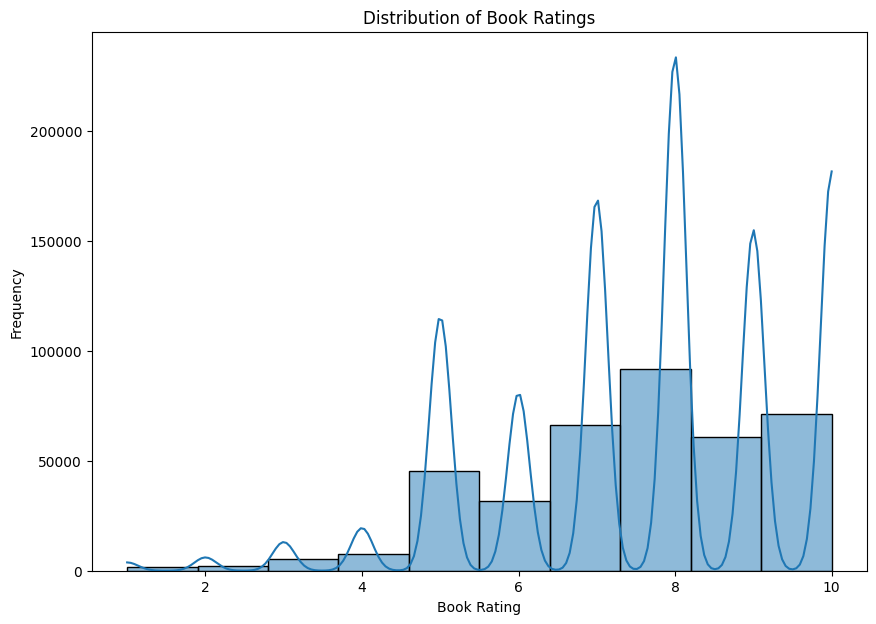

In [26]:
plt.figure(figsize=(10, 7))
sns.histplot(df_selected['Book-Rating'], bins=10, kde=True)
plt.title('Distribution of Book Ratings')
plt.xlabel('Book Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Replace non-numeric values with '0'
final_df['Year-Of-Publication'] = final_df['Year-Of-Publication'].replace(['Gallimard', 'DK Publishing Inc'], '0')

# Convert specific columns to integers
final_df['User-ID'] = final_df['User-ID'].astype(int)
final_df['Book-Rating'] = final_df['Book-Rating'].astype(int)
final_df['Age'] = final_df['Age'].astype(int)
final_df['Year-Of-Publication'] = final_df['Year-Of-Publication'].astype(int)

# Convert specific columns to strings
final_df['ISBN'] = final_df['ISBN'].astype(str)
final_df['Book-Title'] = final_df['Book-Title'].astype(str)
final_df['Book-Author'] = final_df['Book-Author'].astype(str)
final_df['Publisher'] = final_df['Publisher'].astype(str)
final_df['Location'] = final_df['Location'].astype(str)

In [ ]:
# Define which columns are categorical and numerical
categorical_cols = ['ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'Location']
numerical_cols = ['User-ID', 'Age', 'Year-Of-Publication']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

In [ ]:
# Split data into train and test sets
X = final_df.drop(['Book-Rating'], axis=1)
y = final_df['Book-Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Fit and transform preprocessing on training data, and transform on test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Save the fitted preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Apply VarianceThreshold to reduce dimensionality
selector = VarianceThreshold(threshold=0.1)
X_train_selected = selector.fit_transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

# **The Tensorflow Model**

This model is predicting Book-Rating

In [ ]:
# Define and compile the model with SGD optimizer and a lower learning rate
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_selected.shape[1],)),  # Use the number of selected features as input shape
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
sgd = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Include profiler_callback in your model.fit() call
history = model.fit(
    X_train_selected, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=2048,
    callbacks=[early_stopping]
)

Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 15.6880 - mean_squared_error: 15.6880 - val_loss: 14.9002 - val_mean_squared_error: 14.9002
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 14.8256 - mean_squared_error: 14.8256 - val_loss: 14.8734 - val_mean_squared_error: 14.8734
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 14.8173 - mean_squared_error: 14.8173 - val_loss: 14.8469 - val_mean_squared_error: 14.8469
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 14.7862 - mean_squared_error: 14.7862 - val_loss: 14.8507 - val_mean_squared_error: 14.8507
Epoch 5/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.7363 - mean_squared_error: 14.7363 - val_loss: 14.8104 - val_mean_squared_error: 14.8104
Epoch 6/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.7011 - mean_squared_error: 14.7011 - val_loss: 14.7683 - val_mean_squared_error: 14.7683
Epoch 7/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.7535 - mean_squared_error

# **Evaluating The Model**

In [ ]:
# Evaluate the model
loss, mse = model.evaluate(X_test_selected, y_test)
print("Mean Squared Error:", mse)

4709/4709 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 14.3998 - mean_squared_error: 14.3998
Mean Squared Error: 14.417152404785156


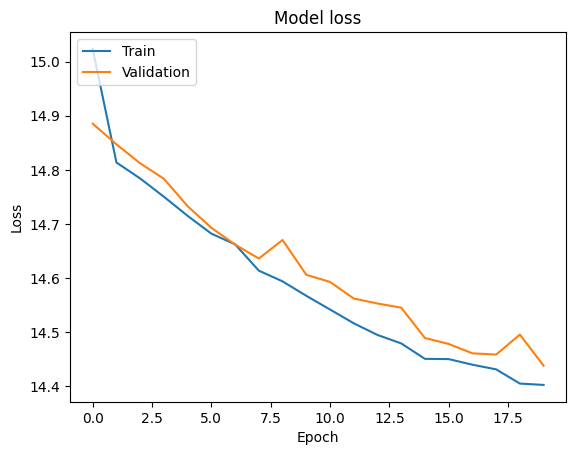

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The model demonstates on training and validation a downwards trend. A decreasing loss over epochs. Thus indicating that the model is learning from the data and improving it's predictive ability

# **Book Recommendation considering Rating**

Using the model, for any given user we can predict and give recommendations on what to read next.

In [ ]:
model.save('tf_model.h5')
loaded_model = load_model('tf_model.h5')

In [ ]:
# Load the fitted preprocessor
preprocessor = joblib.load('preprocessor.pkl')

# Transform X_test using the loaded preprocessor
X_test_preprocessed = preprocessor.transform(X_test)

# Fit the selector with X_train_selected (output of preprocessor before VarianceThreshold)
X_train_preprocessed = preprocessor.transform(X_train)
selector = VarianceThreshold(threshold=0.1)  # Adjust threshold as needed
X_train_selected = selector.fit_transform(X_train_preprocessed)

# Apply the same selector to X_test_preprocessed
X_test_selected = selector.transform(X_test_preprocessed)

# Ensure X_test_selected has the correct shape
print(f"X_test_selected shape: {X_test_selected.shape}")

# Predict using the loaded model
predicted_ratings = loaded_model.predict(X_test_selected)
user_id = X_test.iloc[0]['User-ID']
recommended_books = X_test.iloc[np.argsort(predicted_ratings[:,0])[::-1][:5]]

def print_recommendations(recommended_books, user_id):
    print(f"Top 5 recommended books for user {user_id}:\n")
    for i, row in recommended_books.iterrows():
        print(f"Book {i+1}:")
        print(f"Title: {row['Book-Title']}")
        print(f"Author: {row['Book-Author']}")
        print(f"Publisher: {row['Publisher']}")
        print()

# Print the recommended books for the user
print_recommendations(recommended_books, user_id)

X_test_selected shape: (150660, 3)
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Top 5 recommended books for user 114444:

Book 366944:
Title: Blood Retribution : A Lee Nez Novel (Lee Nez)
Author: David Thurlo
Publisher: Forge Books

Book 363392:
Title: SPQR VIII: The River God's Vengeance (Decius Metellus, 8)
Author: John Maddox Roberts
Publisher: St. Martin's Minotaur

Book 366355:
Title: Unwilling Accomplice : A Munch Mancini Crime Novel (Munch Mancini Novels (Hardcover))
Author: Barbara Seranella
Publisher: Scribner

Book 365052:
Title: Beloved Imposter (Berkley Sensation)
Author: Patricia Potter
Publisher: Berkley Publishing Group

Book 367042:
Title: Agyar
Author: Steven Brust
Publisher: Orb Books



# **Saving the Model**

In [ ]:
# Save the model
model.save('tf_model.h5')

# **Tensorflow Model Training with Ratings and Age**

In [ ]:
# Dropping Image Columns
books_df.drop(books_df.columns[5:], axis=1, inplace=True)

# Merge datasets
merged_df = pd.merge(ratings_df, books_df, on='ISBN')
final_df = pd.merge(merged_df, users_df, on='User-ID')

# Drop NA values
final_df.dropna(inplace=True)

# Replace non-numeric values with '0'
final_df['Year-Of-Publication'] = final_df['Year-Of-Publication'].replace(['Gallimard', 'DK Publishing Inc'], '0')

# Convert specific columns to integers
final_df['User-ID'] = final_df['User-ID'].astype(int)
final_df['Book-Rating'] = final_df['Book-Rating'].astype(int)
final_df['Age'] = final_df['Age'].astype(int)
final_df['Year-Of-Publication'] = final_df['Year-Of-Publication'].astype(int)

# Convert specific columns to strings
final_df['ISBN'] = final_df['ISBN'].astype(str)
final_df['Book-Title'] = final_df['Book-Title'].astype(str)
final_df['Book-Author'] = final_df['Book-Author'].astype(str)
final_df['Publisher'] = final_df['Publisher'].astype(str)
final_df['Location'] = final_df['Location'].astype(str)

# Define which columns are categorical and numerical
categorical_cols = ['ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'Location']
numerical_cols = ['User-ID', 'Age', 'Year-Of-Publication']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

# Split data into train and test sets
X = final_df.drop(['Book-Rating'], axis=1)
y = final_df['Book-Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform preprocessing on training data, and transform on test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Save the fitted preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Apply VarianceThreshold to reduce dimensionality
selector = VarianceThreshold(threshold=0.1)  # Adjust threshold as needed
X_train_selected = selector.fit_transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

# Print shapes of selected datasets
print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"X_test_selected shape: {X_test_selected.shape}")

# Define and compile the model with SGD optimizer and a lower learning rate
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_selected.shape[1],)),  # Use the number of selected features as input shape
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
sgd = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Include profiler_callback in your model.fit() call
history = model.fit(
    X_train_selected, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=2048,
    callbacks=[early_stopping, profiler_callback]
)

# Evaluate the model
loss, mse = model.evaluate(X_test_selected, y_test)
print("Mean Squared Error:", mse)

# Save the model
model.save('book_rating_model_with_age_selected_features.h5')

# Load the model for further training or prediction
loaded_model = tf.keras.models.load_model('book_rating_model_with_age_selected_features.h5')

# Load the fitted preprocessor
preprocessor = joblib.load('preprocessor.pkl')

# Further training with new data
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Transform new training and test data using the loaded preprocessor
new_X_train_preprocessed = preprocessor.transform(new_X_train)
new_X_test_preprocessed = preprocessor.transform(new_X_test)

# Ensure new_X_train_preprocessed has the correct shape
print(f"new_X_train_preprocessed shape: {new_X_train_preprocessed.shape}")
print(f"new_X_test_preprocessed shape: {new_X_test_preprocessed.shape}")

# Reshape new data to match model's input shape
new_X_train_selected = selector.transform(new_X_train_preprocessed)
new_X_test_selected = selector.transform(new_X_test_preprocessed)

# Ensure selected data shapes
print(f"new_X_train_selected shape: {new_X_train_selected.shape}")
print(f"new_X_test_selected shape: {new_X_test_selected.shape}")

# Recreate the optimizer for the loaded model
sgd = SGD(learning_rate=0.01, momentum=0.9)
loaded_model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])

# Continue training the loaded model with profiling
history = loaded_model.fit(new_X_train_selected, new_y_train, epochs=10, validation_split=0.2, batch_size=2048, callbacks=[early_stopping, new_profiler_callback])

# Evaluate the model
loss, mse = loaded_model.evaluate(new_X_test_selected, new_y_test)
print("Mean Squared Error after further training:", mse)



X_train_selected shape: (602637, 3)
X_test_selected shape: (150660, 3)
Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 15.4528 - mean_squared_error: 15.4528 - val_loss: 14.8775 - val_mean_squared_error: 14.8775
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.8268 - mean_squared_error: 14.8268 - val_loss: 14.8438 - val_mean_squared_error: 14.8438
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.7758 - mean_squared_error: 14.7758 - val_loss: 14.8168 - val_mean_squared_error: 14.8168
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 14.7126 - mean_squared_error: 14.7126 - val_loss: 14.7837 - val_mean_squared_error: 14.7837
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.7016 - mean_squared_error: 14.7016 - val_loss: 14.7532 - val_mean_squared_error: 14.7532
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.6824 - mean_squared_error: 14.6824 - val_loss: 14.7138 - val_mean_squared_error: 14.7138
Epoch 7/10
236/2

# **Visulization of Training and Validation losses**

Visulization of training and validation losses over time; model training with ratings and model training with ratings and age

In [ ]:
# Define a function to train and return history
def train_model_and_get_history(X_train_selected, y_train, X_test_selected, y_test, include_age=False):
    # Define model architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_selected.shape[1],)),  # Use the number of selected features as input shape
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compile the model with SGD optimizer
    sgd = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])

    # Implement early stopping to prevent overfitting
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Setup TensorFlow Profiler for further training
    log_dir = "logs/profile/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    profiler_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, profile_batch=(100, 200))

    # Train the model
    history = model.fit(X_train_selected, y_train, epochs=10, validation_split=0.2, batch_size=2048, callbacks=[early_stopping, profiler_callback])

    # Evaluate the model
    loss, mse = model.evaluate(X_test_selected, y_test)
    print(f"Mean Squared Error: {mse}")

    return model, history

# Train model without 'Age' feature
model_without_age, history_without_age = train_model_and_get_history(X_train_selected, y_train, X_test_selected, y_test)

# Train model with 'Age' feature
model_with_age, history_with_age = train_model_and_get_history(new_X_train_selected, new_y_train, new_X_test_selected, new_y_test, include_age=True)

# Extract data from history for model without 'Age'
train_loss_without_age = history_without_age.history['loss']
val_loss_without_age = history_without_age.history['val_loss']

# Extract data from history for model with 'Age'
train_loss_with_age = history_with_age.history['loss']
val_loss_with_age = history_with_age.history['val_loss']

# Create traces for model without 'Age'
trace1 = go.Scatter(x=np.arange(1, len(train_loss_without_age)+1), y=train_loss_without_age, mode='lines', name='Train Loss (Without Age)')
trace2 = go.Scatter(x=np.arange(1, len(val_loss_without_age)+1), y=val_loss_without_age, mode='lines', name='Validation Loss (Without Age)')

# Create traces for model with 'Age'
trace3 = go.Scatter(x=np.arange(1, len(train_loss_with_age)+1), y=train_loss_with_age, mode='lines', name='Train Loss (With Age)')
trace4 = go.Scatter(x=np.arange(1, len(val_loss_with_age)+1), y=val_loss_with_age, mode='lines', name='Validation Loss (With Age)')

# Create layout for the plot
layout = go.Layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0.1, y=1.1, orientation='h'),
)

# Combine traces into a data list
data = [trace1, trace2, trace3, trace4]

# Create figure and plot it
fig = go.Figure(data=data, layout=layout)

# Display the plot
fig.show()


Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 15.5471 - mean_squared_error: 15.5471 - val_loss: 14.8919 - val_mean_squared_error: 14.8919
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.8037 - mean_squared_error: 14.8037 - val_loss: 14.8557 - val_mean_squared_error: 14.8557
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.8206 - mean_squared_error: 14.8206 - val_loss: 14.8413 - val_mean_squared_error: 14.8413
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.7848 - mean_squared_error: 14.7848 - val_loss: 14.8031 - val_mean_squared_error: 14.8031
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.7487 - mean_squared_error: 14.7487 - val_loss: 14.7779 - val_mean_squared_error: 14.7779
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.7259 - mean_squared_error: 14.7259 - val_loss: 14.7494 - val_mean_squared_error: 14.7494
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.7028 - mean_squared_error

# **Book Recommendation considering both Rating and Age**

In [ ]:
# Define which columns are categorical and numerical
categorical_cols = ['ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'Location']
numerical_cols = ['User-ID', 'Age', 'Year-Of-Publication']  # Include Age as a numerical feature

# Drop NA values if any
final_df.dropna(inplace=True)

# Convert specific columns to integers (if needed)
final_df['User-ID'] = final_df['User-ID'].astype(int)
final_df['Book-Rating'] = final_df['Book-Rating'].astype(int)
final_df['Age'] = final_df['Age'].astype(int)
final_df['Year-Of-Publication'] = final_df['Year-Of-Publication'].astype(int)

# Convert specific columns to strings (if needed)
final_df['ISBN'] = final_df['ISBN'].astype(str)
final_df['Book-Title'] = final_df['Book-Title'].astype(str)
final_df['Book-Author'] = final_df['Book-Author'].astype(str)
final_df['Publisher'] = final_df['Publisher'].astype(str)
final_df['Location'] = final_df['Location'].astype(str)

# Split data into train and test sets
X = final_df.drop(['Book-Rating'], axis=1)
y = final_df['Book-Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing pipeline including age
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

# Fit and transform preprocessing on training data, and transform on test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Save the fitted preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Apply VarianceThreshold to reduce dimensionality
selector = VarianceThreshold(threshold=0.1)  # Adjust threshold as needed
X_train_selected = selector.fit_transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

# Save the fitted selector
joblib.dump(selector, 'selector.pkl')

# Print shapes of selected datasets
print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"X_test_selected shape: {X_test_selected.shape}")


X_train_selected shape: (602637, 3)
X_test_selected shape: (150660, 3)


In [ ]:
# Define and compile the model with SGD optimizer and a lower learning rate
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_selected.shape[1],)),  # Use the number of selected features as input shape
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
sgd = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train_selected, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=2048,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, mse = model.evaluate(X_test_selected, y_test)
print("Mean Squared Error:", mse)

# Save the model
model.save('book_rating_model_with_age_selected_features.h5')

Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 15.6763 - mean_squared_error: 15.6763 - val_loss: 14.9057 - val_mean_squared_error: 14.9057
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 14.8321 - mean_squared_error: 14.8321 - val_loss: 14.8674 - val_mean_squared_error: 14.8674
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 14.8033 - mean_squared_error: 14.8033 - val_loss: 14.8408 - val_mean_squared_error: 14.8408
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.7978 - mean_squared_error: 14.7978 - val_loss: 14.8213 - val_mean_squared_error: 14.8213
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 14.7754 - mean_squared_error: 14.7754 - val_loss: 14.7948 - val_mean_squared_error: 14.7948
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 14.7467 - mean_squared_error: 14.7467 - val_loss: 14.7644 - val_mean_squared_error: 14.7644
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 14.6991 - mean_squared_error

In [ ]:
# Load the fitted preprocessor
preprocessor = joblib.load('preprocessor.pkl')

# Load the fitted selector
selector = joblib.load('selector.pkl')

# Load the fitted model
loaded_model = load_model('book_rating_model_with_age_selected_features.h5')

# Transform X_test using the loaded preprocessor
X_test_preprocessed = preprocessor.transform(X_test)

# Ensure X_test_preprocessed has the correct shape
print(f"X_test_preprocessed shape: {X_test_preprocessed.shape}")

# Apply the same selector to X_test_preprocessed
X_test_selected = selector.transform(X_test_preprocessed)

# Ensure X_test_selected has the correct shape
print(f"X_test_selected shape: {X_test_selected.shape}")

# Predict using the loaded model
predicted_ratings = loaded_model.predict(X_test_selected)
user_id = X_test.iloc[0]['User-ID']
recommended_books = X_test.iloc[np.argsort(predicted_ratings[:, 0])[::-1][:5]]

def print_recommendations(recommended_books, user_id):
    print(f"Top 5 recommended books for user {user_id}:\n")
    for i, row in recommended_books.iterrows():
        print(f"Book {i+1}:")
        print(f"Title: {row['Book-Title']}")
        print(f"Author: {row['Book-Author']}")
        print(f"Publisher: {row['Publisher']}")
        print()

# Print the recommended books for the user
print_recommendations(recommended_books, user_id)


X_test_preprocessed shape: (150660, 487031)
X_test_selected shape: (150660, 3)
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Top 5 recommended books for user 114444:

Book 363423:
Title: Revenge : A Novel
Author: Mary Morris
Publisher: St. Martin's Press

Book 362744:
Title: In a Dark House (Crombie, Deborah)
Author: Deborah Crombie
Publisher: William Morrow

Book 365584:
Title: Dust of Eden
Author: Thomas Sullivan
Publisher: Onyx Books

Book 364791:
Title: Tampa Burn (White, Randy Wayne)
Author: Randy Wayne White
Publisher: Putnam Publishing Group

Book 366050:
Title: Freedom's Gate
Author: NAOMI KRITZER
Publisher: Spectra

